In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve
from sklearn.metrics import auc, make_scorer, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import KFold, LeaveOneOut
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold
from xgboost import XGBRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.base import BaseEstimator, TransformerMixin
seed = 42

In [48]:
df = pd.read_csv('diabetes.csv')
df.head(5)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [49]:
df = pd.read_csv('diabetes.csv')

X =  df.iloc[:,0:8].values
y = df.Outcome.values

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=0)
model = LogisticRegression(penalty='none', max_iter=10000)
model.fit(Xtrain, ytrain)
ypred = model.predict(Xtest)

ytest_prob = model.predict_proba(Xtest)

In [50]:
def rmse(y,ypr):
    return np.sqrt(mean_squared_error(y, ypr, squared=True))

def MSE(y, ypr):
    return np.mean((y-ypr)**2)

# Class Balanced


In [51]:
counts= df.Outcome.value_counts()

baseline_accuracy = round(counts[0]/(counts[0]+counts[1]), 3)
print("Baseline Accuracy is:", baseline_accuracy)

Baseline Accuracy is: 0.651


# R2

In [52]:
def cal_r2(y, ypred):
    RSS = np.sum((y - ypred) ** 2)
    TSS = sum((y - np.mean(y))**2)
    return 1 - RSS/TSS
cal_r2(ytest, ypred)

0.1731954662954871

In [53]:
r2_score(ytest, ypred)

0.1731954662954862

# Statistical Significance 
Group insignificant labels into two new statistically significant labels.

In [54]:
df = pd.read_csv('forestfires.csv')
((df.month.value_counts()/df.month.value_counts().sum())*100).round(2)

aug    35.59
sep    33.27
mar    10.44
jul     6.19
feb     3.87
jun     3.29
oct     2.90
apr     1.74
dec     1.74
jan     0.39
may     0.39
nov     0.19
Name: month, dtype: float64

In [55]:
# Group insignificant labels into two new statistically significant labels.
df.month.replace({'feb':'fj', 'jun':'fj'}, inplace=True)

df.month.replace({'oct':'oadjmn', 'apr':'oadjmn', 'dec':'oadjmn', 
    'jan':'oadjmn', 'may':'oadjmn', 
    'nov':'oadjmn'}, inplace=True)

In [56]:
((df.month.value_counts()/df.month.value_counts().sum())*100).round(2)

aug       35.59
sep       33.27
mar       10.44
oadjmn     7.35
fj         7.16
jul        6.19
Name: month, dtype: float64

# Performance Mesurement

- **TP = “True Positive”.** i.e. your classifier predicted 1; it was correct.
- **FP = “False Positive”.** i.e. your classifier predicted 1; it was incorrect (Type I error).
- **FN = “False Negative”.** i.e. your classifier predicted 0; it was incorrect (Type II error).
- **TN = “True Negative”.** i.e. your classifier predicted 0; it was correct.


In [57]:
def compute_performance(yhat, y, classes):
    # First, get tp, tn, fp, fn
    tp = sum(np.logical_and(yhat == classes[1], y == classes[1]))
    tn = sum(np.logical_and(yhat == classes[0], y == classes[0]))
    fp = sum(np.logical_and(yhat == classes[1], y == classes[0]))
    fn = sum(np.logical_and(yhat == classes[0], y == classes[1]))
    return tp, tn, fp, fn

## Confusion_matrix

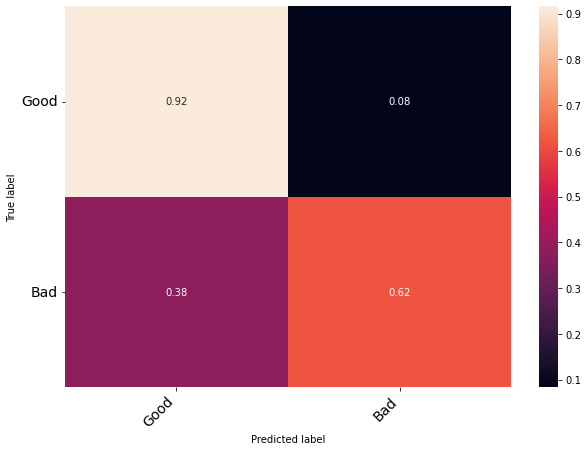

In [58]:
def get_confusion_matrix(ytest, ypred):
    # Calculate confusion matrix
    confusion_matrix_rf = confusion_matrix(y_true = ytest, y_pred = ypred)

    # Turn matrix to percentages
    confusion_matrix_rf = confusion_matrix_rf.astype('float') / confusion_matrix_rf.sum(axis=1)[:, np.newaxis]

    # Turn to dataframe
    df_cm = pd.DataFrame(confusion_matrix_rf, index=['Good', 'Bad'], columns=['Good', 'Bad'])

    # Parameters of the image
    figsize = (10,7)
    fontsize=14

    # Create image
    fig = plt.figure(figsize=figsize)
    heatmap = sns.heatmap(df_cm, annot=True, fmt='.2f')

    # Make it nicer
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0,  ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)

    # Add labels
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    # Plot!
    plt.show()

get_confusion_matrix(ytest, ypred)

## Measurement:

- Precision: What percentage of all positive predictions were correct?
  $$
  Precision = \frac{\# \ \text{True Positive}}{\#\ \text{Predicted Positive}}
  $$
- Recall: What percentage of all positive samples were recalled?

$$
Recall = \frac{\# \ \text{True Positive}}{\# \ \text{Class Positive}}
$$

- F-Measure: A combined metric which accounts for precision and recall in a single measure.

$$
F-Measure = 2 * (\frac{\text{Precision} * \text{Recall}}{\text{Precision} + {Recall}})
$$

In [59]:
def compute_performance_2(yhat, y, classes):
    # First, get tp, tn, fp, fn
    tp = sum(np.logical_and(yhat == classes[1], y == classes[1]))
    tn = sum(np.logical_and(yhat == classes[0], y == classes[0]))
    fp = sum(np.logical_and(yhat == classes[1], y == classes[0]))
    fn = sum(np.logical_and(yhat == classes[0], y == classes[1]))
    
    # Accuracy
    acc = (tp + tn) / (tp + tn + fp + fn)
    
    # Recall
    # "Of all the + in the data, how many do I correctly label?"
    recall = tp / (tp + fn)    
    
    # Sensitivity
    # "Of all the + in the data, how many do I correctly label?"
    sensitivity = recall
    
    # Specificity
    # "Of all the - in the data, how many do I correctly label?"
    specificity = tn / (fp + tn)
        
    # print("Accuracy:",round(acc,3),"Recall:",round(recall,3),
    #       "Sensitivity:",round(sensitivity,3),"Specificity:",round(specificity,3))
    return acc, recall, sensitivity, specificity

## Threshold

In [60]:
threshold = 0.6

ytest_prob = model.predict_proba(Xtest)
ypred = model.classes_[(ytest_prob[:,1]>threshold).astype(int)]
tp, tn, fp, fn = compute_performance(ypred, ytest, model.classes_)
Acc = (tp + tn) / (tp + tn + fp + fn)
print("Acc: %.5f" % Acc)

Acc: 0.81818


## ROC and AUC

- If Area Under Receiver Operating
  Characteristic Curve (AUROC) is
  1, classifier is perfect
- If AUROC is 0.5, classifier is no
  better than random chance.
- If AUROC is 0, classifier is
  worst possible (TPR=0, FPR=1)

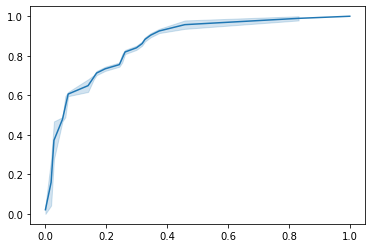

In [61]:
fpr, tpr, _ = roc_curve(ytest, ytest_prob[:,1], pos_label=1)
ax = sns.lineplot(x = fpr, y = tpr)

In [62]:
AUC = roc_auc_score(ytest, ytest_prob[:,1])
print("AUC: "+ str(AUC))

AUC: 0.8663750248558362


In [63]:
AUC = auc(fpr, tpr)
print("AUC: "+ str(AUC))

AUC: 0.8663750248558362


# Grid Search

In [64]:
XGB = XGBRegressor(verbosity=1, objective='reg:squarederror', booster='gbtree',       
                    n_jobs=-1, gamma=0.001, subsample=0.632, colsample_bytree=1,           # Subsample ratio of columns when constructing each tree.
                    colsample_bylevel=1, colsample_bynode=1, base_score=0.5,               # Global bias. Set to average of the target rate.
                    random_state=0)

param_grid = dict({
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6 ,7],
    'n_estimators' : [350, 400, 450, 500]})

df = pd.read_csv('energy_appliances_standard.csv')
EnergyTrain,  EnergyTest = train_test_split(df, test_size = 0.3, random_state = 20201107)

val_train = EnergyTrain.sample(frac = 0.6, random_state = 0)    # The seed.

cv_object = StratifiedKFold(n_splits=2)

GridXGB = GridSearchCV(XGB, param_grid, cv = cv_object,      # Cross-validation object.  
                       scoring = 'neg_mean_absolute_percentage_error', n_jobs = -1,          # Parallel jobs. -1 is "all you have"
                       refit = False, verbose = 0)
val_y = val_train['Appliances']
val_x = val_train.drop("Appliances",axis=1)

GridXGB.fit(val_x, val_y)

GridSearchCV(cv=StratifiedKFold(n_splits=2, random_state=None, shuffle=False),
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    callbacks=None, colsample_bylevel=1,
                                    colsample_bynode=1, colsample_bytree=1,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=0.001,
                                    gpu_id=None, grow_policy=None,
                                    importance_type=N...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=-1, num_parallel_tr

In [65]:
GridXGB.best_params_

{'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 450}

# One hot encoding VS Label encoding
Label encoding and one hot encoding both can turn category into numeric variables
In most scenarios, one hot encoding is the preferred way to convert a categorical variable into a numeric variable because label encoding makes it seem that there is a ranking between values.

In [66]:
data = pd.read_csv('footballer_reduced.csv')
data.head(5)

,age,height_cm,weight_kg,work_rate_att,overall
0,20,175,70,Medium,58
1,29,183,80,High,65
2,35,183,78,High,67
3,24,178,72,Medium,69
4,23,173,73,Medium,70


## One hot encoding

In [67]:
data = pd.get_dummies(data, drop_first=True)
data.head(5)

,age,height_cm,weight_kg,overall,work_rate_att_Low,work_rate_att_Medium
0,20,175,70,58,0,1
1,29,183,80,65,0,0
2,35,183,78,67,0,0
3,24,178,72,69,0,1
4,23,173,73,70,0,1


## Label encoding

In [68]:
data = pd.read_csv('footballer_reduced.csv')

dataLE = data.copy()
label_encoder = preprocessing.LabelEncoder()
dataLE['work_rate_att']= label_encoder.fit_transform(data['work_rate_att'])
dataLE.head(5)

,age,height_cm,weight_kg,work_rate_att,overall
0,20,175,70,2,58
1,29,183,80,0,65
2,35,183,78,0,67
3,24,178,72,2,69
4,23,173,73,2,70


# PipeLine

In [69]:
M1 = Pipeline([
    ('lr1', LinearRegression())
])

M2 = Pipeline([
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('lr3', LinearRegression())
])

## Custom Transformer

`Temperature (temp)` and `Rain (rain)` may be important features, so let's extend model 1 by adding a *cubed* term for temp and a *squared* term for rain.

In [70]:
class KeyFeatures(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X = X.assign(temp2 = X.temp**3)
        X = X.assign(rain2 = X.rain**2)
        return X

# Create a pipeline for model 3 (M3) [ /8 marks]
M3 = Pipeline([
    ('temp_cubic_rain_square', KeyFeatures()),
    ('lr2', LinearRegression())
])

# K-flod cross-validation

Model Choose  
Choose the simplest model which has the lowest cross-validated training loss.

In [71]:
LR  = LinearRegression()

# KFold cross-validated loss with shuffling
kf = KFold(n_splits=5, shuffle=True, random_state=seed)
cv_scores = cross_val_score(LR, Xtrain, ytrain, cv=kf, scoring=make_scorer(rmse))

In [72]:
# Define Kfold crossvalidation 
x = np.arange(20)
print(x,'\n')
kf = KFold(n_splits=5, shuffle=False)
# Shuffle = True : random test set
for train, test in kf.split(x):
    print("Train set: %s, Test set: %s" % (train, test))

# Leave One Out crossvalidation when dataset is too small
x=np.arange(20)
loo = LeaveOneOut()
for train,test in loo.split(x):
    print("%s %s" % (train, test))


sc = make_scorer(MSE) 

# KFold cross-validated loss without shuffling
kf = KFold(n_splits=5, shuffle=False, random_state=None)
cv_scores = cross_val_score(LinearRegression(), Xtrain, ytrain, cv=kf, scoring=sc)

# KFold cross-validated loss with shuffling
kf = KFold(n_splits=5, shuffle=True, random_state=seed)
cv_scores = cross_val_score(LinearRegression(), Xtrain, ytrain, cv=kf, scoring=sc)

# Leave One Out cross-validated loss
kf = LeaveOneOut()
cv_scores = cross_val_score(LinearRegression(), X, y, cv=kf, scoring=sc) 
# for Leave One Out you use the full data set

print(f'List of CV loss:', cv_scores)
print(f"Average CV loss: %.3f +/- %.3f" % (cv_scores.mean(), cv_scores.std()))

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19] 

Train set: [ 4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19], Test set: [0 1 2 3]
Train set: [ 0  1  2  3  8  9 10 11 12 13 14 15 16 17 18 19], Test set: [4 5 6 7]
Train set: [ 0  1  2  3  4  5  6  7 12 13 14 15 16 17 18 19], Test set: [ 8  9 10 11]
Train set: [ 0  1  2  3  4  5  6  7  8  9 10 11 16 17 18 19], Test set: [12 13 14 15]
Train set: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15], Test set: [16 17 18 19]
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19] [0]
[ 0  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19] [1]
[ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19] [2]
[ 0  1  2  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19] [3]
[ 0  1  2  3  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19] [4]
[ 0  1  2  3  4  6  7  8  9 10 11 12 13 14 15 16 17 18 19] [5]
[ 0  1  2  3  4  5  7  8  9 10 11 12 13 14 15 16 17 18 19] [6]
[ 0  1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19] [7]
[ 0  1  2 

# Learning Curve

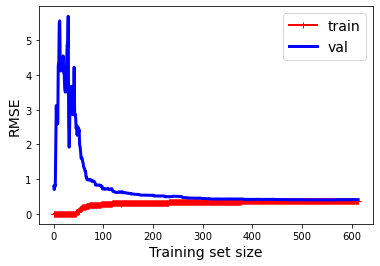

In [73]:
def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=10)
    train_errors, val_errors = [], []
    for m in range(1, len(X_train) + 1):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))

    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")
    plt.legend(loc="upper right", fontsize=14)
    plt.xlabel("Training set size", fontsize=14)
    plt.ylabel("RMSE", fontsize=14)    

polynomial_regression = Pipeline([
        ("poly_features", PolynomialFeatures(degree=2, include_bias=False)), # play with degree
        ("lin_reg", LinearRegression()),
    ])

plot_learning_curves(polynomial_regression, X, y)
plt.show()                   

# Gradient Descent

## Batch Gradient Descent

In [74]:
np.random.seed(42)
X = 2 * np.random.rand(100, 1) 
X_b = np.c_[np.ones((100, 1)), X]

X_new = np.array([[0], [2]])
X_new_b = np.c_[np.ones((2, 1)), X_new]

y = 4 + 3 * X + np.random.randn(100, 1)

In [75]:
eta = 0.1  # learning rate
n_iterations = 1000
m = len(X_b)

theta = np.random.randn(2,1)  # random initialization

for iteration in range(n_iterations):
    gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
    theta = theta - eta * gradients

In [76]:
def plot_gradient_descent(theta, eta, theta_path=None):
    m = len(X_b)
    plt.plot(X, y, "b.")
    n_iterations = 1000
    for iteration in range(n_iterations):
        if iteration < 10:
            y_predict = X_new_b.dot(theta)
            style = "b-" if iteration > 0 else "r--"
            plt.plot(X_new, y_predict, style)
        gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
        theta = theta - eta * gradients
        if theta_path is not None:
            theta_path.append(theta)
    plt.xlabel("$x_1$", fontsize=18)
    plt.axis([0, 2, 0, 15])
    plt.title(r"$\eta = {}$".format(eta), fontsize=16)

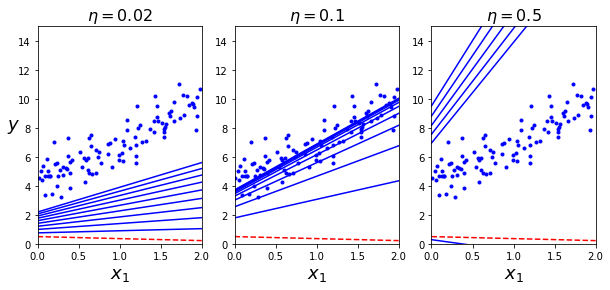

In [77]:
np.random.seed(42)
theta = np.random.randn(2,1)  # random initialization

plt.figure(figsize=(10,4))
plt.subplot(131); plot_gradient_descent(theta, eta=0.02); plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(132); plot_gradient_descent(theta, eta=0.10)
plt.subplot(133); plot_gradient_descent(theta, eta=0.50)

plt.show()

## Stochastic Gradient Descent:
In practice, the N could be very large, therefore, computing the loss could be very expensive.

Therefore we sample some small set of data examples as minibatch and use the minibatch to estimate the true gradient.

We want to gradually reduce the learning rate. The steps start out large (which helps make quick progress and escape local minima), then get smaller and smaller. The "learning schedule" determines the learning rate at each iteration.

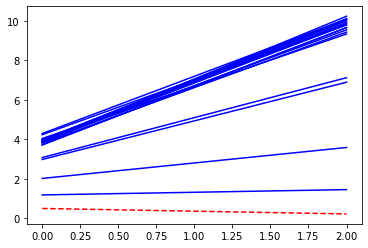

In [78]:
m = len(X_b)
np.random.seed(42)
n_epochs = 50

t0, t1 = 5, 50  # learning schedule hyperparameters
def learning_schedule(t):
    return t0 / (t + t1)

theta = np.random.randn(2,1)  # random initialization

for epoch in range(n_epochs):
    for i in range(m):
        if epoch == 0 and i < 20:                    
            y_predict = X_new_b.dot(theta)           
            style = "b-" if i > 0 else "r--"         
            plt.plot(X_new, y_predict, style)        
        random_index = np.random.randint(m)
        xi = X_b[random_index:random_index+1]
        yi = y[random_index:random_index+1]
        gradients = 2 * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(epoch * m + i)
        theta = theta - eta * gradients  

sgd_reg = SGDRegressor(max_iter=1000, tol=1e-3, eta0=0.1, random_state=42) 
sgd_reg.fit(X, y.ravel()) # "ravel" to flatten the array
sgd_reg.intercept_, sgd_reg.coef_
score = sgd_reg.score(X, y.ravel())

# Mini-Batch Gradient Descent

In [79]:
n_iterations = 50
minibatch_size = 20

np.random.seed(42)
theta = np.random.randn(2,1)  # random initialization

t0, t1 = 200, 1000
def learning_schedule(t):
    return t0 / (t + t1)

t = 0
for epoch in range(n_iterations):
    shuffled_indices = np.random.permutation(m)
    X_b_shuffled = X_b[shuffled_indices]
    y_shuffled = y[shuffled_indices]
    for i in range(0, m, minibatch_size):
        t += 1
        xi = X_b_shuffled[i:i+minibatch_size]
        yi = y_shuffled[i:i+minibatch_size]
        gradients = 2/minibatch_size * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(t)
        theta = theta - eta * gradients